In [1]:
# for importing data
import os
import qiime2
import numpy as np
import pandas as pd
from scipy.stats import sem
from skbio.stats.distance import permanova
from skbio import DistanceMatrix, OrdinationResults
from scripts.helper import temporal_plot
pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

cmap_methods = {'Aitchison':'#377eb8', 
                'Bray-Curtis':'#ff7f00', 
                'CTF':'#4daf4a', 
                'Jaccard':'#999999', 
                'UniFrac':'#984ea3', 
                'W-UniFrac':'#e41a1c'}

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import matadata 
mf = pd.read_csv('../../data/DIABIMMUNE-Qiita-11884/11884_20190508-173103-added-month-abx.txt',
                 sep='\t',index_col=0)
# fix up dataframes for qiime2
csecmap = {True:'Csection',False:'Vaginal'} # map for csection
mf['csectionq2'] = [csecmap[x] for x in mf.csection] # rename csect

# get pcoa metric types
pcoa_name = {'Bray Curtis':'bray_curtis_distance_matrix.qza',
             'Jaccard':'jaccard_distance_matrix.qza',
             'UniFrac':'gUniFrac_alpha0_distance_matrix.qza',
             'W-UniFrac':'gUniFrac_alpha1_distance_matrix.qza',
             'Aitchison':'aitchison_distance_matrix.qza'}
# emoty dict to fill with tables
distance_tables = {}
# where output is stored
output_path = '../../data/DIABIMMUNE-Qiita-11884/q2-analysis/core-metrics-results'
# for each metric and location import the pcoa table
for metric_name,file_name in pcoa_name.items():
    
    file_name = os.path.join(output_path,file_name)
    # import OrdinationResults
    dist = qiime2.Artifact.load(file_name).view(DistanceMatrix)
    # match metadata and pc-table along with prop. explained
    distance_tables[metric_name] = [mf.reindex(dist.ids),dist.to_data_frame()]

# import OrdinationResults
distance_ctf = qiime2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/distance_matrix.qza').view(DistanceMatrix)
subject_trajectory = qiime2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/state_subject_ordination.qza').view(pd.DataFrame)
# fix up dataframes for qiime2
csecmap = {'True':'Csection','False':'Vaginal'} # map for csection
subject_trajectory['csectionq2'] = [csecmap[x] for x in subject_trajectory.csection]
# make loadings
distance_tables['CTF'] = [subject_trajectory, distance_ctf.to_data_frame()]


In [3]:
permanova_results = {}
for metric_, (mf_, dist_) in distance_tables.items():
    for timepoint, mdf in mf_.groupby('month'):
        # sub-Distance
        distance_matched = DistanceMatrix(dist_.loc[mdf.index,
                                                    mdf.index])
        # PERMANOVA
        res_ = permanova(distance_matched, mdf['csectionq2'])
        permanova_results[(metric_,
                           timepoint,
                           'F.Model')] = [res_['test statistic']]
        permanova_results[(metric_,
                           timepoint,
                           'Pr(>F)')] = [res_['p-value']]

permanova_results = pd.DataFrame(permanova_results).T.reset_index()
permanova_results.columns = ['metric','month','stat','value']
permanova_results = permanova_results.replace({'Bray Curtis':'Bray-Curtis'})
permanova_results = permanova_results[~permanova_results.month.isin([1, 5, 19, 23, 33])]
permanova_results.to_csv('../../results/DIABIMMUNE-PERMANOVA.tsv', sep='\t')
permanova_results.head(5)

,metric,month,stat,value
0,Bray-Curtis,0,F.Model,2.270468
1,Bray-Curtis,0,Pr(>F),0.010000
4,Bray-Curtis,2,F.Model,1.961042
5,Bray-Curtis,2,Pr(>F),0.030000
6,Bray-Curtis,3,F.Model,2.050627


In [4]:
fbymthd = {method_:resdf_[resdf_.stat.isin(['F.Model'])].set_index('month') 
           for method_, resdf_ in permanova_results.groupby('metric')}

adonisfold = pd.DataFrame({k:["%.2f ± %.2f"%(np.mean(fbymthd['CTF'].loc[df.index, :].value.values/df.value.values),
                                 sem(fbymthd['CTF'].loc[df.index, :].value.values/df.value.values))]
              for k,df in fbymthd.items()},['Fold-Change']).T.sort_index()
adonisfold.to_csv('../../results/DIABIMMUNE-PERMANOVA-fold-change.tsv', sep='\t')
adonisfold


,Fold-Change
Aitchison,6.48 ± 0.41
Bray-Curtis,5.24 ± 0.24
CTF,1.00 ± 0.00
Jaccard,6.65 ± 0.50
UniFrac,5.58 ± 0.22
W-UniFrac,4.26 ± 0.50


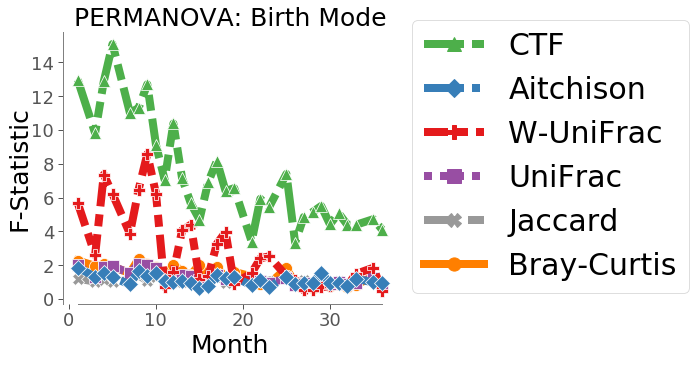

In [5]:
from matplotlib.ticker import MaxNLocator

# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 12}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 18

fig,ax = plt.subplots(1,1,figsize=(6,5))

# plot labels
y_label = 'F-Statistic'
x_label = 'Month' 
title = 'PERMANOVA: Birth Mode'
data_plot = permanova_results[permanova_results.stat.isin(['F.Model'])]
#data_plot = data_plot[~data_plot.month.isin([1, 5, 19, 23, 33])]
data_plot['month'] += 1.0
data_plot['month'] = data_plot['month'].astype(int)

# generate plot
ax = temporal_plot('month','value', data_plot, ax,
                    title, x_label, y_label, 25, 25, 25,
                    hue='metric', style='metric',min_x=1,
                   max_x=36, err_style='bars',
                   cmap=cmap_methods)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1][:-1], labels[::-1][:-1],
            prop={'size':30}, loc=2, 
            bbox_to_anchor=(1.0, 1.1),
            fancybox=True, framealpha=0.8,ncol=1
            , markerscale=1.1, facecolor="white")

# save the figure to file
plt.savefig('../../results/DIABIMMUNE-PERMANOVA-Fstat.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [27]:
data_plot['month'].min()

1

In [22]:
3*12

36